In [1]:
# For wider display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook")

# A useful plotting function that displays joint distribution of x and y, 
# and marginalized distribuitions of each.
# Not important
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)

# Gaussian Process Example (30 mins)


## Gaussian Process (unconditioned)

An uncondititoned Gaussian Process can be viewed as a random function $G(x)$, specified by the mean (one-point function)
$$\langle G(x)\rangle \equiv \mu(x),$$ 
and covariance function (two-point function)
$$\langle\delta G(x) \delta G(x')\rangle \equiv k(x, x').$$
And we assume any combinations of the random variable $\{ G(x_1), G(x_2), \cdots, G(x_n)\}$ forms an $n$-dimensional Normal distribution with the above mean and pairwise covaraince.

**Let's examine a conceret example**

### Single and multi-variated Gaussian distribution

1. A single-variable Gaussian distribution is charactered by a mean $\mu$ and a standard deviation $\sigma$

$$f(x; \mu, \sigma) = \frac{1}{(2\pi)^{1/2}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

2. A multi-varaite Gaussian distribution is charactered by the means $\mu(x_1), \mu(x_2),\cdots$ of each variable and the covariance matrix:
$$ \Sigma = \begin{bmatrix} s_{11} & s_{12} & \cdots\\
s_{21} & s_{22} & \cdots\\ 
\cdots & \cdots & \cdots
\end{bmatrix}
$$
with $\sigma_{12}^2 <\sigma_{11} \sigma_{22}$


$$f(x_1, x_2; \mu_1, \mu_2, \Sigma_{ij}) = \frac{1}{(2\pi)^{1/2}\sqrt{|\Sigma|}} \exp\left\{-\frac{1}{2}\sum_{i,j=1}^2(x_i-\mu_i)^T \Sigma_{ij}^{-1} (x_j-\mu_j)\right\} $$

We will take a specific form of the kernel function 
$$k(x_1, x_2) = C^2 \exp\left\{-\frac{|x_1-x_2|^2}{2L^2}\right\}$$
**Output values of close input points $x_{1,2}$ have strongly correlated / close outputs $y_{1,2}$**

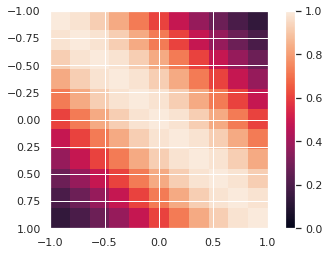

In [3]:
########## Block 2 ##############

# The Gaussian-like two-point function for filling the elements of the covariance matrix
# cov(x1, x2) = C^2 exp(-(x1-x2)^2/(2L^2) )
# C: std of the distriubtion at one point
# L: correlation length scale
@np.vectorize
def kernel(x1, x2, C, L):
    return C**2 * np.exp(-.5*(x1-x2)**2/L**2)

# visualize a 10 by 10 covariance matrix:
N = 11
x = np.linspace(-1,1,N)
mean = np.zeros_like(x)
cov = kernel(*np.meshgrid(x,x), C=1, L=1)
plt.imshow(cov, extent=[-1,1,1,-1], vmin=0, vmax=1)
plt.colorbar()

Text(0.5, 1.0, '$|x_i-x_j|/L = 0.21$')

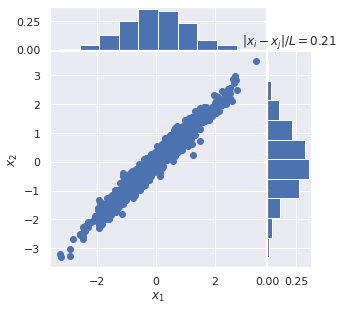

In [4]:
########## Block 3 ##############
# Function that samples N-D normal distribution 
# with x = [-2.0, ... N points ... 2.0]
#      mean = [0, ..., 0]
#      C_ij = Cov(x_i, x_j) = kernel(x_i, x_j; C, L)
# generate 1000 lines by default
def ND_Normal(N, C, L, nsamples=1000):
    x = np.linspace(-2,2,N)
    mean = np.zeros_like(x)
    cov = kernel(*np.meshgrid(x,x), C, L)
    return x, np.random.multivariate_normal(mean, cov, nsamples)

# Generate an ensemble of size-20 random vectors from a distribution with C=1 and L=1
x, Y = ND_Normal(N=20, C=1, L=1)

# Checkout the joint distribution of the ith and jth random varible
i, j = 1,2
hist_1d_2d(Y[:,i], Y[:,j], '$x_{}$'.format(i), '$x_{}$'.format(j))
plt.title(r"$|x_i-x_j|/L = {:1.2f}$".format(np.abs(x[i]-x[j])/1))

# <How does it change when you change the separation of x_i and x_j?>

Another way to look at this multi-variate normal, plot $x$ and realizations $y(x)$ as a scattered plot. Since close inputs gaurantees close outputs, the resulting plots are samples of smooth functions with the given variance and correlation function.

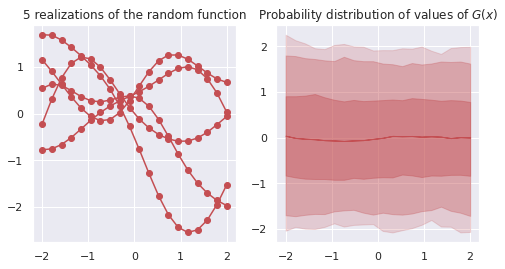

In [5]:
########## Block 4 ##############
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
_ = ax1.plot(x, Y[:5].T, 'ro-')
ax1.set_title("5 realizations of the random function")

CLbins = [0,60,90,95]
ax2.set_title("Probability distribution of values of $G(x)$")
for CL, opacity in zip(CLbins, [1., .4, .3, .2, .1]):
    lower, upper = np.percentile(Y, [50-CL/2., 50+CL/2.], axis=0)
    ax2.fill_between(x, lower, upper, color='r', alpha=opacity)


### GP-1: Conditioning the GP
Now, we would like to pick a particular subset of random functions that comes near to the points
$$(x^*_i, y^*_i) =  (-2,-1), (0,0.5),(2,0.7)$$.
To do this, we picks random functions that statisfies $$|G(x^*_i)-y^*_i | < \epsilon$$

Text(0, 0.5, 'y')

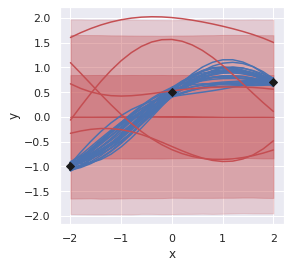

In [6]:
########## Block 5 ##############

# generate a large ensemble with correlation length 2
x, Y = ND_Normal(N=21, C=1, L=2, nsamples=100000)

# a filter "cut" to select those random functions that approaches (within +/- 0.1)
# the desired points (-2,1), (0, 0.5), and (2, 0.7)
epsilon = 0.1
cut = ( np.abs(Y[:,0]+1)<epsilon ) \
    & ( np.abs(Y[:,10]-.5)<epsilon ) \
    & ( np.abs(Y[:,20]-.7)<epsilon ) \

# Now plot the 
fig, ax = plt.subplots(1,1, figsize=(4,4))
CLbins = [0,60,90,95]
for CL, opacity in zip(CLbins, [1., .4, .3, .2, .1]):
    lower, upper = np.percentile(Y, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(x, lower, upper, color='r', alpha=opacity)
ax.errorbar([-2,0,2],[-1,.5,.7],yerr=epsilon,fmt='kD')
_ = ax.plot(x, Y[cut].T,'b-')
_ = ax.plot(x, Y[:5].T,'r-')
plt.xlabel("x")
plt.ylabel("y")

# Questions: 
# What if you use a L that is very small compared to the 
# typical lengh-scale of variaton of the data points.

The conditioned set of random functions provides an interpolation of the three conditioned points with their spread as uncertainties. The natural inclusion of interpolation uncertainty is a big advantage of GP in the workflow of Bayesian analysis of complex model.

### The variance and the correlations length $C^2, L$.
Strickly spearking, the variance and the correlation length is unknown for a given set of data to be interpolated. An common practice is to optimize the values of $C$ and $L$ in the "fitting" so that it maximumize the likelihood of desribing the data. The systematic tuning for an optimal set of $C$ and $L$ is the so-called training process.

For practical use, we can use well developed GP modules in sklearn. It implements different kinds of kernel functions and training algorithms.

https://scikit-learn.org/stable/tutorial/basic/tutorial.html

https://scikit-learn.org/stable/modules/gaussian_process.html

## Applying sklearn GP to 1D inference/interpolation

**The problem**: given values of function $F(x)$ on a sparse grid $x_i, i=1,2,\cdots$, use Gaussain process emulator (regressor) to infer the functional form of the $F$.

$$F(x) = x^2 + \sin(5x)$$

Text(0, 0.5, '$y$')

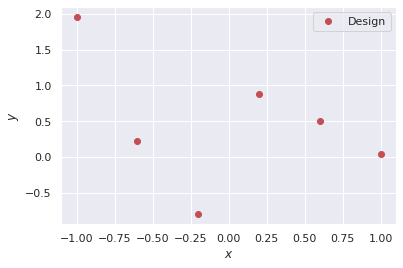

In [7]:
########## Block 6 ##############
# The function to be emulated / interpolated
def F(x):
    return x**2+np.sin(5*x)

# We only take six "measurements" of this "unknown function" within [-1, 1]
# In this example, we consider these measurements are accurate
x_design = np.linspace(-1,1,6)
y_design = F(x_design)
plt.plot(x_design, y_design, 'ro', label='Design')
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [8]:
########## Block 7 ##############
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# Train the emulator, specify the kernel functions 
kernel = \
    1. * kernels.RBF(length_scale=1., # <-- Initial guesses of C and L: C=1, L=1
                     length_scale_bounds=(.1,10) # <-- we will let the optimzier to find an optimal value of 
                                                 # L within 0.1 to 10.0
    )

# initialize the guassian process, and allow it to optimzie 5 times, incase it falls in local minima
gp = GPR(kernel=kernel, n_restarts_optimizer=5)
# Train it on the design points
gp.fit(np.atleast_2d(x_design).T, y_design)
# Print out the optimzied C and L
print("C^2 = ", gp.kernel_.get_params()['k1'])
print("L = ", gp.kernel_.get_params()['k2'])

# Score for describing the training data
print("This score of describing the training data:", gp.score(np.atleast_2d(x_design).T, y_design))
# Score for describing a another set of data (validation points), 
# this is important to make sure we are not overfitting!
xv = np.linspace(-1,1,31)
print("This score of describing validation data:", gp.score(np.atleast_2d(xv).T, F(xv)) )


C^2 =  1.05**2
L =  RBF(length_scale=0.315)
This score of describing the training data: 1.0
This score of describing validation data: 0.9866051842951153


In [9]:
########## Block 8 ##############
# A wrapper to make predictions from GP, and also returns the standard deviation of the ensmeble 
# of conditioned random functions as an interpolation uncertainty.
# Uncertainty estimation is important for applying Bayes theorem.
# You will find in many cases with high-dimensional parameter space that 
# interpolation uncertainties dominates the experimetnal one and maybe even theoretical one
def predict(x, gp):
    mean, cov = gp.predict(return_cov=True, X=np.atleast_2d(x).T)
    return mean, np.sqrt(np.diag(cov))

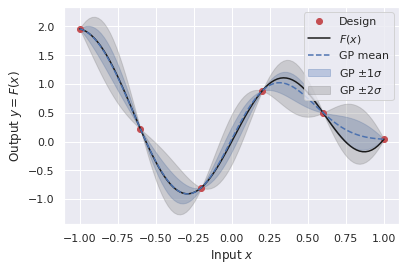

In [10]:
########## Block 9 ##############
# compare the mean, +/-1 and 2 sigma bands of the GP prediction to the truth

x = np.linspace(-1,1,101)
y, ystd = predict(x, gp)
plt.plot(x_design, y_design, 'ro', label='Design')
plt.plot(x, F(x),'k-', label=r'$F(x)$')
plt.plot(x, y,'b--', label=r'GP mean')
plt.fill_between(x, y-ystd, y+ystd, color='b', alpha=.3, label=r'GP $\pm 1\sigma$')
plt.fill_between(x, y-2*ystd, y+2*ystd, color='gray', alpha=.3, label=r'GP $\pm 2\sigma$')
plt.xlabel(r"Input $x$")
plt.ylabel(r"Output $y=F(x)$")
plt.legend()

# Question: 
# 1. Can you still get a sensible interpolation if you choose less design points?
# 2. Does this Gaussian Process provide good extrapolation? What happens when you make predictions outside [-1,1]